In [1]:
import torch
from mlp import make_dataset, CharacterLevelMLP, Linear
import matplotlib.pyplot as plt
from torch.optim import Adam
from pathlib import Path
from torch.nn.functional import cross_entropy
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
linear1 = Linear(10,5,False)

In [2]:
names_file = Path("./names.txt")
context_window = 3
X , Y, itos = make_dataset(names_file, context_window=context_window)

In [3]:
train_X, eval_X, train_Y, eval_Y = train_test_split(X,Y,test_size=0.2)

In [4]:
val_X, test_X, val_Y, test_Y = train_test_split(eval_X,eval_Y,test_size=0.5)

In [5]:
EPOCHS = 1000
batch_size=32
block_size=context_window
lre = torch.linspace(-3, 0, EPOCHS)
lrn = 10**lre
LEARNING_RATE = 0.1520

In [6]:
n_embedding = 10
n_hidden = 200
vocab_size = 27

## Custom Neural Net

In [14]:
C = torch.randn((vocab_size, n_embedding))
W1 = torch.randn((n_embedding*block_size, n_hidden))
b1 = torch.randn(n_hidden)
W2 = torch.randn((n_hidden, vocab_size))
b2 = torch.randn(vocab_size)

batch_normalization_gain = torch.ones((1,n_hidden))
batch_normalization_bias = torch.ones((1,n_hidden))

parameters = [C,W1,b1,W2,b2]

train_steps = []
losses = []

eval_steps = []
eval_losses = []

for i in range(EPOCHS):
    
    for p in parameters:
        p.requires_grad = True
        
    # Minibatch sampling
    random_index = torch.randint(0,train_X.shape[0],(batch_size,))
    
    X_batch = train_X[random_index]
    Y_batch = train_Y[random_index]
    
    embeddings = C[X_batch]
    hidden_dim = embeddings.view((embeddings.shape[0], -1)) @ W1 + b1
    hidden_dim = batch_normalization_gain* (hidden_dim - hidden_dim.mean(0,keepdim=True))/hidden_dim.std(0,keepdim=True) + batch_normalization_bias
    hidden_dim = torch.tanh(hidden_dim)
    logits = hidden_dim @ W2 + b2
    
    loss = cross_entropy(logits, Y_batch)
    losses.append(loss.item())
    train_steps.append(i)
        
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # learning_rate = lrn[i]
    for p in parameters:
        p.data += -LEARNING_RATE * p.grad
        
    
    if i%10 == 0:
        # Disable params grads
        for p in parameters:
            p.requires_grad = False
        
        embeddings = C[val_X]
        hidden_dim = embeddings.view((embeddings.shape[0], -1)) @ W1 + b1
        hidden_dim = batch_normalization_gain* (hidden_dim - hidden_dim.mean(0,keepdim=True))/hidden_dim.std(0,keepdim=True) + batch_normalization_bias
        hidden_dim = torch.tanh(hidden_dim)
        logits = hidden_dim @ W2 + b2
        
        loss = cross_entropy(logits, val_Y)
        eval_losses.append(loss.item())
        eval_steps.append(i)

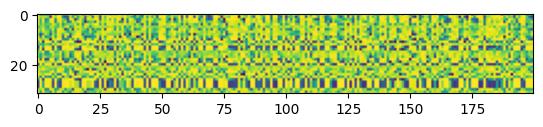

In [16]:
plt.imshow(hidden_dim.detach())

In [25]:
mlp_network = CharacterLevelMLP(vocab_size, n_embedding, n_hidden, context_window)
adam = Adam(mlp_network.parameters(), lr=LEARNING_RATE)

train_steps = []
losses = []

eval_steps = []
eval_losses = []

for i in range(EPOCHS):
    
    # Minibatch sampling
    random_index = torch.randint(0,train_X.shape[0],(batch_size,))
    
    X_batch = train_X[random_index]
    Y_batch = train_Y[random_index]
    
    mlp_network.train()
    logits = mlp_network(X_batch)
    
    loss = cross_entropy(logits, Y_batch)
    losses.append(loss.item())
    train_steps.append(i)

    # Clear gradients from previous iteration
    adam.zero_grad()
        
    loss.backward()
    
    # Update parameters
    adam.step()
    
    if i%10 == 0:
        
        mlp_network.eval()
        logits = mlp_network(val_X)
        
        loss = cross_entropy(logits, val_Y)
        eval_losses.append(loss.item())
        eval_steps.append(i)

## Plot results

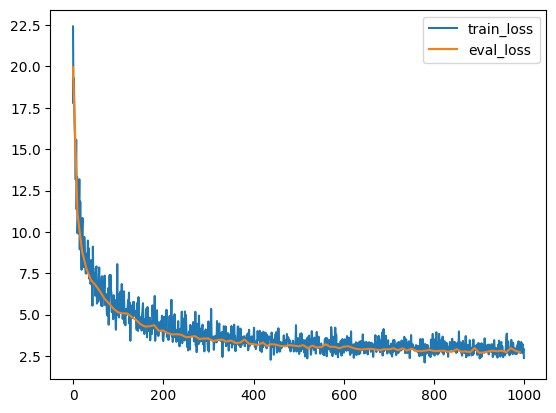

In [15]:
plt.plot(losses, label="train_loss")
plt.plot(eval_steps,eval_losses, label="eval_loss")
plt.legend()

In [48]:
logits = torch.randn(4) * 10
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
logits, probs, loss


(tensor([10.7770, -2.3846, -4.9909, -3.1768]),
 tensor([1.0000e+00, 1.9231e-06, 1.4195e-07, 8.7090e-07]),
 tensor(15.7678))